# Project: Satellite Wildfire Detection using CNN
### **Objective:** Implement a binary classification model (Wildfire vs. NoWildfire) using a Convolutional Neural Network.

## 1. Setup & Preprocessing
Setting up the environment, defining hyperparameters, and handling potential image corruption issues.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import ImageFile
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fix for "image file is truncated" error with PIL
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Hyperparameters
IMG_SHAPE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-3
DATA_RATIO = 1/3    # Downsampling to 33% because there is too much images
SEED = 42

# Paths
ROOT_DIR = './'
TRAIN_DIR = os.path.join(ROOT_DIR, 'train')
TEST_DIR = os.path.join(ROOT_DIR, 'test')
CLASSES = ['nowildfire', 'wildfire']

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.20.0


## 2. Data Sampling
We randomly sample 33% of the training and testing data to speed up the pipeline.

In [2]:
def create_dataset_dataframe(base_dir, classes, sample_fraction):
    filepaths = []
    labels = []

    for label in classes:                                         # Fetching all image paths
        search_path = os.path.join(base_dir, label, '*')
        files = glob.glob(search_path)
        
        if len(files) > 0:                                        # Random sampling without replacement
            sample_size = int(len(files) * sample_fraction)
            selected_files = np.random.choice(files, size=sample_size, replace=False)
            
            filepaths.extend(selected_files)
            labels.extend([label] * sample_size)
            
    df = pd.DataFrame({'filename': filepaths, 'class': labels})    # Shuffle the dataset
    return df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# Generate reduced DataFrames
train_df = create_dataset_dataframe(TRAIN_DIR, CLASSES, DATA_RATIO)
test_df = create_dataset_dataframe(TEST_DIR, CLASSES, DATA_RATIO)

print(f"Reduced Train Set: {len(train_df)} images")
print(f"Reduced Test Set: {len(test_df)} images")

Reduced Train Set: 10083 images
Reduced Test Set: 2100 images


## 3. Data Generators
Applied data augmentation on the training set to improve model generalization.

In [3]:
# Train generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.15 
)

# Test/Val generator (Rescaling only)
test_datagen = ImageDataGenerator(rescale=1./255)

# Training pipeline
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Validation pipeline
val_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

# Testing pipeline
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='class',
    target_size=IMG_SHAPE,
    batch_size=1,
    class_mode='binary',
    shuffle=False 
)

Found 8571 validated image filenames belonging to 2 classes.
Found 1512 validated image filenames belonging to 2 classes.
Found 2100 validated image filenames belonging to 2 classes.


## 4. CNN Architecture Definition
Implementing a Sequential CNN. Added BatchNormalization to speed up convergence and Dropout to reduce overfitting. Output layer uses sigmoid for binary classification.

In [4]:
def build_model(input_shape):
    model = Sequential([
        Input(shape=input_shape + (3,)),

        # Block 1
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Classification Head
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        # Output Layer
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model(IMG_SHAPE)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,940,225 (49.36 MB)

 Trainable params: 12,939,777 (49.36 MB)

 Non-trainable params: 448 (1.75 KB)

## 5. Training with Early Stopping
Using EarlyStopping on val_loss to automatically halt training when performance plateaus.

In [5]:
# Callback configuration
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,             # Stop after 2 epochs without improvement
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 198s 731ms/step - accuracy: 0.8675 - loss: 1.6570 - val_accuracy: 0.1918 - val_loss: 2.5913
Epoch 2/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 132s 493ms/step - accuracy: 0.9002 - loss: 0.3753 - val_accuracy: 0.8882 - val_loss: 0.3279
Epoch 3/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 133s 496ms/step - accuracy: 0.9124 - loss: 0.2552 - val_accuracy: 0.9272 - val_loss: 0.2110
Epoch 4/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 128s 477ms/step - accuracy: 0.9187 - loss: 0.2262 - val_accuracy: 0.9272 - val_loss: 0.2629
Epoch 5/20
268/268 ━━━━━━━━━━━━━━━━━━━━ 131s 488ms/step - accuracy: 0.9266 - loss: 0.2052 - val_accuracy: 0.9325 - val_loss: 0.2223
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 3.


## 6. Model Evaluation and Visualization of Learning Curves
Evaluating performance on the unseen Test Set and checking for Overfitting/Underfitting patterns.


Evaluation on Test Set
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 27s 13ms/step - accuracy: 0.9281 - loss: 0.2369
Accuracy: 92.81%
Loss: 0.2369
2100/2100 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step

Confusion Matrix
[[ 825  115]
 [  36 1124]]

Classification Report
              precision    recall  f1-score   support

  nowildfire       0.96      0.88      0.92       940
    wildfire       0.91      0.97      0.94      1160

    accuracy                           0.93      2100
   macro avg       0.93      0.92      0.93      2100
weighted avg       0.93      0.93      0.93      2100



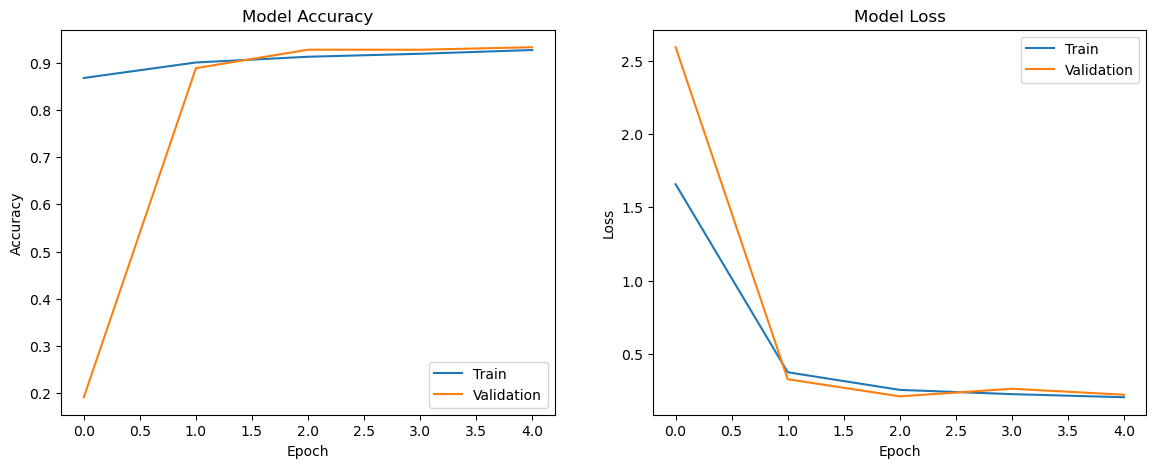

In [6]:
# 1. Global Metrics
print("\nEvaluation on Test Set")
loss, acc = model.evaluate(test_generator, steps=len(test_generator))
print(f"Accuracy: {acc*100:.2f}%")
print(f"Loss: {loss:.4f}")

# 2. Predictions & Confusion Matrix
predictions = model.predict(test_generator, steps=len(test_generator))
y_pred_binary = (predictions > 0.5).astype("int32")
y_true = test_generator.classes

print("\nConfusion Matrix")
print(confusion_matrix(y_true, y_pred_binary))

print("\nClassification Report")
print(classification_report(y_true, y_pred_binary, target_names=CLASSES))

# 3. Visualisation
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy Plot
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss Plot
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.show()

plot_history(history)

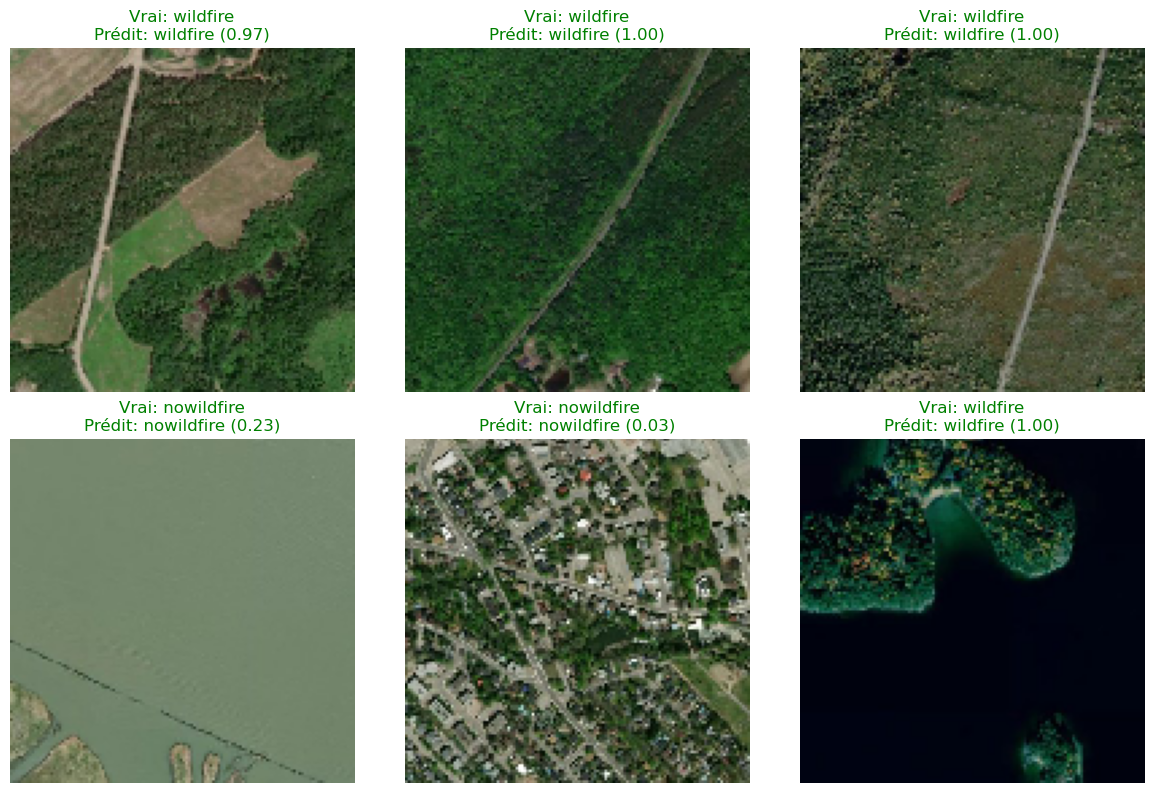

In [7]:
import random
from tensorflow.keras.preprocessing.image import load_img

# 1. Sélection de 6 indices aléatoires
indices = random.sample(range(len(test_df)), 6)

plt.figure(figsize=(12, 8))

# Récupération du mapping inverse (0 -> 'nowildfire', 1 -> 'wildfire')
# Cela permet d'afficher le nom de la classe au lieu d'un chiffre
class_map = {v: k for k, v in train_generator.class_indices.items()}

for i, idx in enumerate(indices):
    # 2. Récupération des infos depuis le DataFrame et les prédictions
    row = test_df.iloc[idx]
    img_path = row['filename']
    true_label = row['class']
    
    # On récupère la probabilité prédite pour cet index
    # (predictions a été généré à l'étape précédente avec shuffle=False)
    pred_prob = predictions[idx][0]
    pred_class_idx = int(pred_prob > 0.5)
    pred_label = class_map[pred_class_idx]
    
    # 3. Chargement et affichage de l'image
    img = load_img(img_path, target_size=IMG_SHAPE)
    
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    
    # Couleur du titre : Vert si correct, Rouge si incorrect
    color = 'green' if true_label == pred_label else 'red'
    
    plt.title(f"Vrai: {true_label}\nPrédit: {pred_label} ({pred_prob:.2f})", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

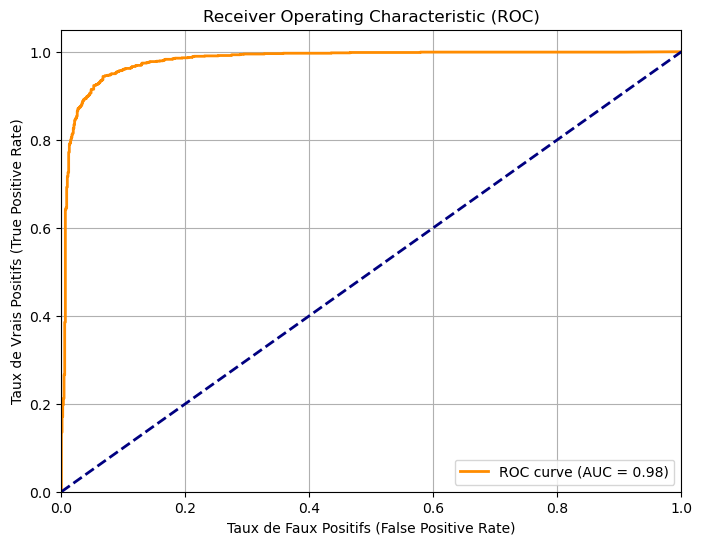

In [8]:
from sklearn.metrics import roc_curve, auc

# 1. Récupération des données adaptées au notebook
# 'test_generator.classes' contient les vrais labels (0 ou 1) ordonnés
y_test = test_generator.classes

# 'predictions' contient les probabilités brutes calculées par model.predict()
# (Nous l'avons déjà calculé dans une étape précédente avec shuffle=False)
y_pred = predictions

# 2. Calcul de la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# 3. Affichage
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Receiver Operating Characteristic (ROC)')
plt.xlabel('Taux de Faux Positifs (False Positive Rate)')
plt.ylabel('Taux de Vrais Positifs (True Positive Rate)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()